In [40]:
!pip install tensorflow matplotlib

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
import matplotlib.pyplot as plt
import os
import numpy as np


In [42]:

# ---------------------------------
# 1. КОНФІГУРАЦІЯ
# ---------------------------------
print("--- Етап 1: Конфігурація ---")

# Шляхи до даних
DATA_DIR = './learning/data_classifier_v2'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Параметри моделі
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128      # 128 або 256 - хороший вибір для великих сетів
COLOR_MODE = 'grayscale'
CHANNELS = 1
NUM_CLASSES = 10    # Дуже важливо! 0-9 плюс клас 10 (сміття)
EPOCHS = 10         # 10 епох для початку. Може знадобитися більше.


--- Етап 1: Конфігурація ---


In [43]:

# ---------------------------------
# 2. ЗАВАНТАЖЕННЯ ДАНИХ (ЕФЕКТИВНО)
# ---------------------------------
print("--- Етап 2: Завантаження даних ---")

# Keras утиліта для завантаження даних з папок
# Вона автоматично знайде класи (0, 1, 2... 10)
# label_mode='categorical' автоматично перетворить ярлики у one-hot
# [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

print("Завантаження TRAIN датасету...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical', # <--- Важливо для categorical_crossentropy
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

print("\nЗавантаження TEST (Validation) датасету...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Перемішування не потрібне для тестування
)

# Отримуємо імена класів (має бути ['0', '1', '10', '2', ...])
class_names = train_dataset.class_names
print(f"\nЗнайдено класи: {class_names}")
if len(class_names) != NUM_CLASSES:
    print(f"ПОМИЛКА: Очікувалось {NUM_CLASSES} класів, але знайдено {len(class_names)}")
    # Тут можна зупинити блокнот


--- Етап 2: Завантаження даних ---
Завантаження TRAIN датасету...
Found 93209 files belonging to 10 classes.

Завантаження TEST (Validation) датасету...
Found 9548 files belonging to 10 classes.

Знайдено класи: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [44]:

# ---------------------------------
# 3. ОПТИМІЗАЦІЯ ПАЙПЛАЙНУ ДАНИХ
# ---------------------------------
print("\n--- Етап 3: Оптимізація пайплайну ---")

# .cache() - кешує дані в пам'ять після першого читання
# .prefetch() - готує наступні батчі, поки GPU тренується
# Це КРИТИЧНО для швидкості тренування

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Пайплайни даних готові.")



--- Етап 3: Оптимізація пайплайну ---
Пайплайни даних готові.


In [45]:
print("\n--- Етап 4: Побудова архітектури (v2.0 з регуляризацією) ---")


# Вхідний шар
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))

# 1. Нормалізація
x = layers.Rescaling(1./255)(inputs)

# === Блок 1 ===
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x) # <--- ДОДАНО

# === Блок 2 ===
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x) # <--- ДОДАНО

# === Блок 3 ===
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x) # <--- ДОДАНО

# === Голова класифікатора ===
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.Dropout(0.5)(x) # <--- Старий шар, залишаємо

# === Вихідний шар ===
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Збираємо модель
model = keras.Model(inputs=inputs, outputs=outputs)


--- Етап 4: Побудова архітектури (v2.0 з регуляризацією) ---


In [46]:
print("\n--- Етап 5: Компіляція моделі (v2.0) ---")

# Ідея №3: Зменшуємо швидкість навчання
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Було 0.001 (default)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Виведемо структуру моделі
model.summary()


--- Етап 5: Компіляція моделі (v2.0) ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,074 (4.36 MB)

 Trainable params: 1,143,370 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [47]:
# 6. НАВЧАННЯ МОДЕЛІ
# ---------------------------------
print("\n--- Етап 6: Початок навчання ---")
print(f"Тренування на {EPOCHS} епох...")

# Створюємо колбек для збереження ТІЛЬКИ найкращої моделі
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/digit_classifier_best.keras', # Збережемо в папку models
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Запускаємо процес навчання
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint] # Додаємо колбек
)

print("\n--- Навчання завершено! ---")



--- Етап 6: Початок навчання ---
Тренування на 10 епох...
Epoch 1/10
728/729 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8516 - loss: 0.5186

2025-11-05 00:19:37.699150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2070', 8 bytes spill stores, 8 bytes spill loads



729/729 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8517 - loss: 0.5183

2025-11-05 00:19:46.695207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_206', 24 bytes spill stores, 24 bytes spill loads



729/729 ━━━━━━━━━━━━━━━━━━━━ 106s 134ms/step - accuracy: 0.9208 - loss: 0.2732 - val_accuracy: 0.9603 - val_loss: 0.1317
Epoch 2/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9627 - loss: 0.1258 - val_accuracy: 0.9553 - val_loss: 0.1554
Epoch 3/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9698 - loss: 0.1021 - val_accuracy: 0.9766 - val_loss: 0.0771
Epoch 4/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9724 - loss: 0.0908 - val_accuracy: 0.9767 - val_loss: 0.0777
Epoch 5/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9745 - loss: 0.0847 - val_accuracy: 0.9786 - val_loss: 0.0713
Epoch 6/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9757 - loss: 0.0787 - val_accuracy: 0.9787 - val_loss: 0.0713
Epoch 7/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9770 - loss: 0.0752 - val_accuracy: 0.9794 - val_loss: 0.0692
Epoch 8/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9775 - loss: 0.0716 - val_accur

In [48]:

# ---------------------------------
# 7. ОЦІНКА ТА ЗБЕРЕЖЕННЯ
# ---------------------------------
print("\n--- Етап 7: Оцінка та збереження ---")

# Оцінка на тестовому наборі (дасть ті ж цифри, що й остання епоха)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nФінальна точність на тестовому наборі: {test_acc*100:.2f}%")

# Збереження фінальної моделі (не обов'язково найкращої)
model.save('./models/digit_classifier_final.keras')
print(f"Фінальну модель збережено в ./models/digit_classifier_final.keras")
print(f"Найкращу модель збережено в ./models/digit_classifier_best.keras")



--- Етап 7: Оцінка та збереження ---
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9795 - loss: 0.0705

Фінальна точність на тестовому наборі: 97.95%
Фінальну модель збережено в ./models/digit_classifier_final.keras
Найкращу модель збережено в ./models/digit_classifier_best.keras



--- Етап 8: Візуалізація результатів ---
Графіки навчання збережено в ./models/training_history.png


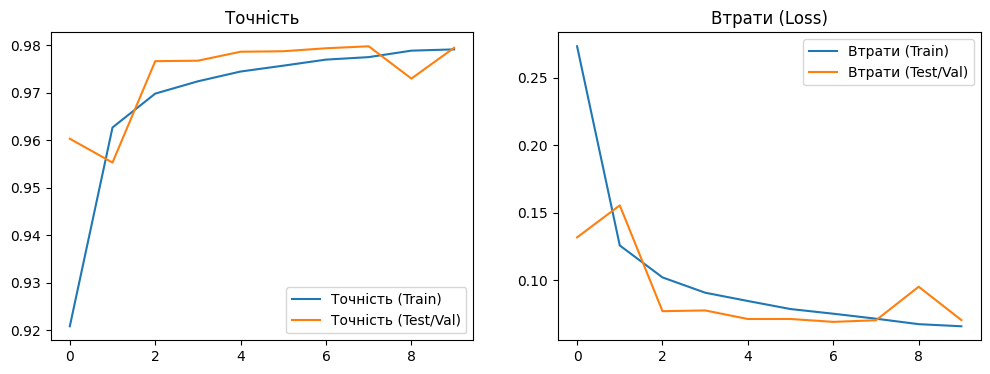

In [49]:

# ---------------------------------
# 8. ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ
# ---------------------------------
print("\n--- Етап 8: Візуалізація результатів ---")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точність (Train)')
plt.plot(epochs_range, val_acc, label='Точність (Test/Val)')
plt.legend(loc='lower right')
plt.title('Точність')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Втрати (Train)')
plt.plot(epochs_range, val_loss, label='Втрати (Test/Val)')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')

plt.savefig('./models/training_history.png')
print("Графіки навчання збережено в ./models/training_history.png")
plt.show()